# Laterality Curves

### import modules

In [1]:
%matplotlib inline

In [2]:
from nilearn import input_data, image, plotting

import os
import sys

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

### get absolute directory of project

In [3]:
# after converstion to .py, we can use __file__ to get the module folder
try:
    thisDir = os.path.realpath(__file__)
# in notebook form, we take the current working directory (we need to be in 'notebooks/' for this!)
except:
    thisDir = '.'
# convert relative path into absolute path, so this will work with notebooks and py modules
supDir = os.path.abspath(os.path.join(os.path.dirname(thisDir), '..'))

supDir

'/data/martin/language_lat'

### get tMap

In [4]:
tDf = pd.DataFrame([
    '%s/data/raw/nii/%s' % (supDir, x)
    for x in os.listdir('%s/data/raw/nii' % supDir) if x.startswith('tMap')
])
tDf.columns = ['tMaps']
tDf.index = [x.split('tMap_')[-1].split('.')[0] for x in tDf['tMaps']]
tDf.sort_index(inplace=True)

In [5]:
tDf.shape

(783, 1)

In [ ]:
tDf.tail()

In [7]:
tMap = tDf.iloc[35].tMaps

In [ ]:
tMap

Activity map in native space on brain-extracted structural image

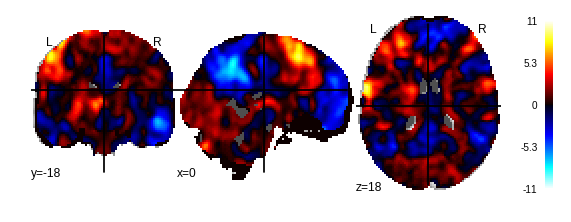

In [10]:
plotting.plot_stat_map(tMap,threshold=0);

### make a mask based on the stats map

We use a masker which encompasses all valid voxel in the tMap

In [11]:
masker = input_data.NiftiMasker(mask_img='%s/data/external/MNI152_T1_2mm_brain_mask.nii.gz'%supDir).fit()

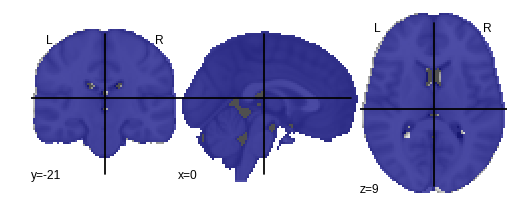

In [12]:
plotting.plot_roi(masker.mask_img_)

### get the language ROIs

In [13]:
languageLeft = '%s/models/tMap_diff_left.nii.gz' % supDir
languageRight = '%s/models/tMap_diff_right.nii.gz' % supDir

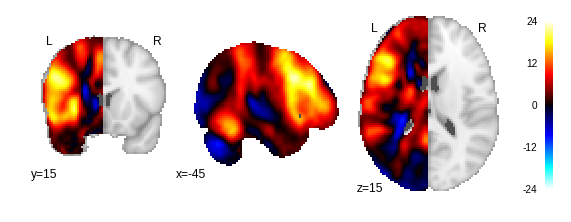

In [15]:
plotting.plot_stat_map(languageLeft,draw_cross=False,cut_coords=(-45,15,15));

### binarize the language ROI at a specific threshold

In [16]:
def makeBinMaskAbs(roi,thresh,masker=masker):
    
    # turn roi image into array
    data = masker.transform( roi )

    # binarize at threshold
    data[data>=thresh] = 1
    data[data!=1] = 0
    
    # turn array back to image
    img = masker.inverse_transform(data)

    return img

In [17]:
d = {}
for pc in np.linspace(1,15,100):
    threshRoi = makeBinMaskAbs(languageLeft,pc)
    a = threshRoi.get_data()
    d[pc] = a[a>0].shape[-1]

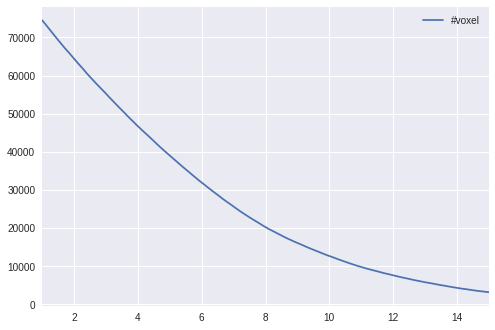

In [18]:
pd.DataFrame(d,index=['#voxel']).T.plot()

In [19]:
def makeBinMask(roi,pc,masker=masker):
    
    # turn roi image into array
    data = masker.transform( roi )
   
    # get rid of negative values
    cutData = data.copy()
    cutData = cutData[cutData>0.01]
    
    # get score corresponding to percentile
    thresh = np.percentile(cutData,pc)

    # binarize at threshold
    data[data>=thresh] = 1
    data[data!=1] = 0
    
    # turn array back to image
    img = masker.inverse_transform(data)

    return img

Here, it is important that we use percentiles, because we would like to modulate ROI size in a linear fashion, but if we use absolute values for thresholding this will not be the case (i.e. it is harder to cross higher thresholds, so 10 and 11 for example would be nearly the same while 1 and 2 would be very different). Also, it is good to keep the smalles ROis still relatively large, as we are only counting voxel and counting doesn't make sense for small ROIs.

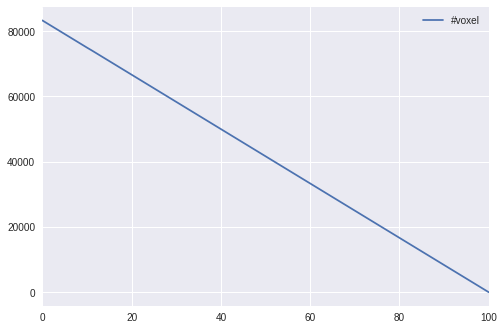

In [20]:
d = {}
for pc in np.linspace(0,100,100):
    threshRoi = makeBinMask(languageLeft,pc)
    a = threshRoi.get_data()
    d[pc] = a[a>0].shape[-1]
pd.DataFrame(d,index=['#voxel']).T.plot()

Example:

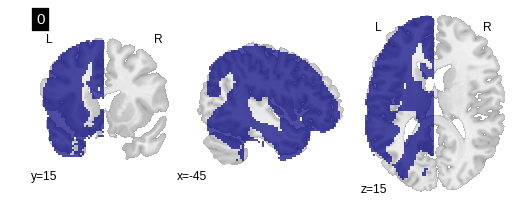

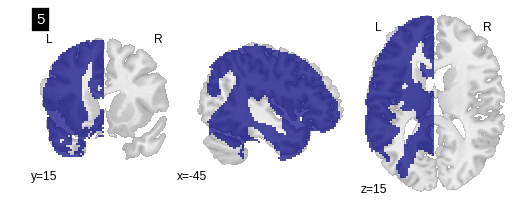

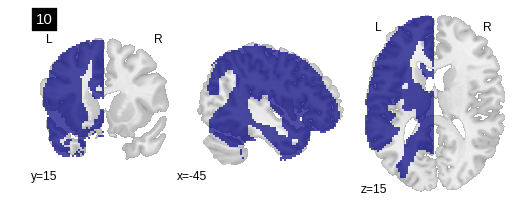

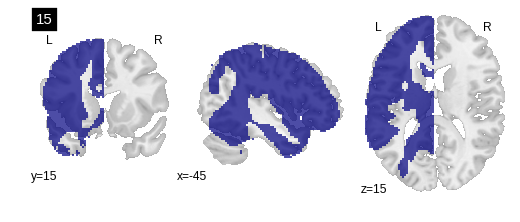

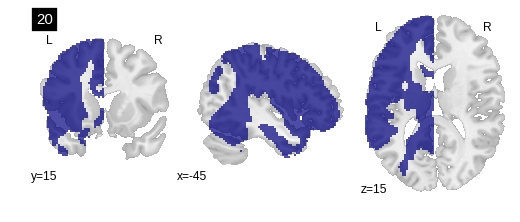

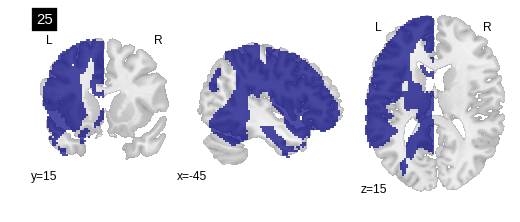

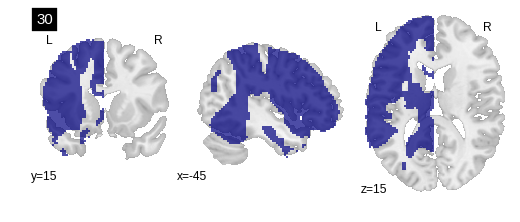

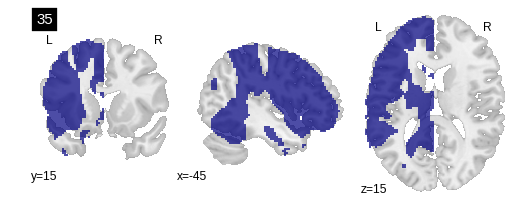

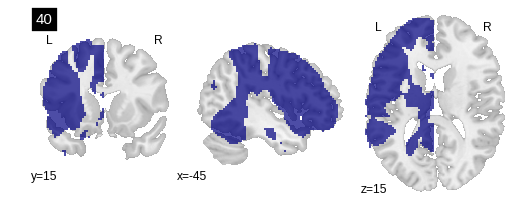

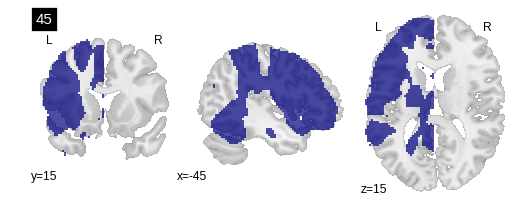

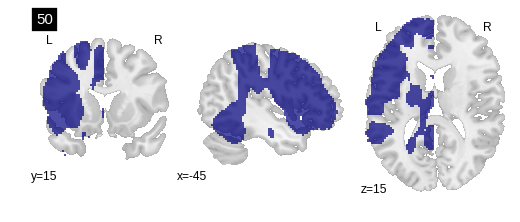

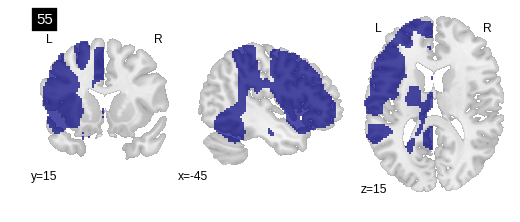

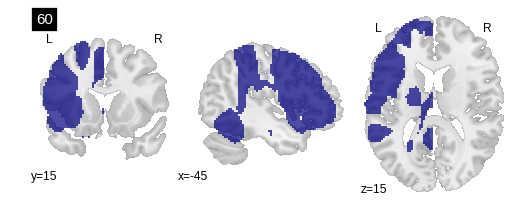

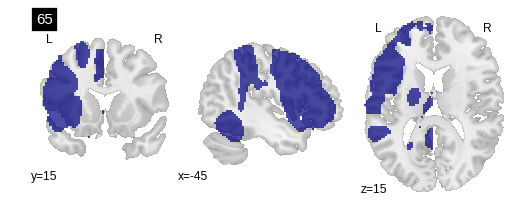

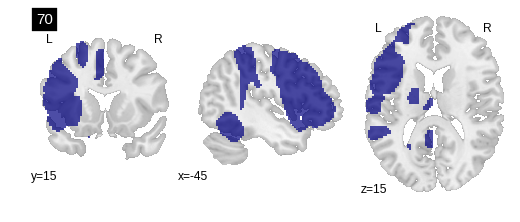

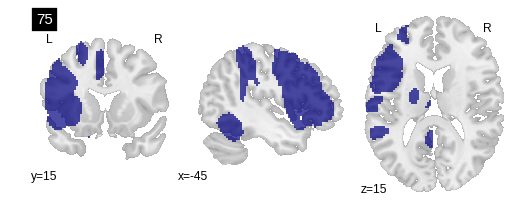

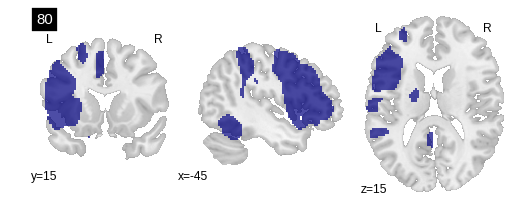

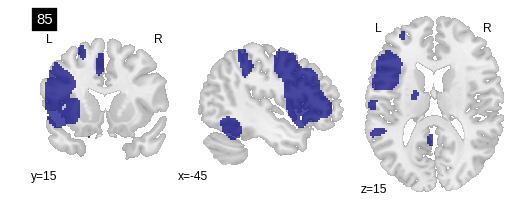

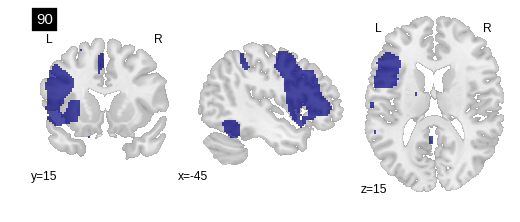

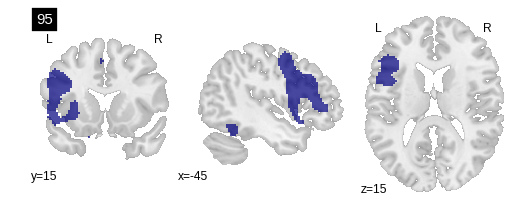

In [19]:
for thresh in np.arange(0,100,5):
    threshRoi = makeBinMask(languageLeft,thresh)
    plotting.plot_roi(threshRoi,
                      bg_img='%s/data/external/ch2better.nii.gz' % supDir,
                      draw_cross=False,
                      cut_coords=(-45,15,15),
                      black_bg=False,
                      colorbar=False,
                      title=thresh)
    plt.show()

In [22]:
fig = plt.figure(figsize=(7,11))

ax = plt.subplot(3,1,1)
ax = plotting.plot_stat_map('%s/data/processed/nii/tMap_diff_values.nii.gz' % supDir,
                            bg_img='%s/data/external/ch2better.nii.gz' % supDir,
                            draw_cross=False,
                            cut_coords=(-45,15,15),
                            black_bg=False,
                            colorbar=False,
                            axes=ax,
                            title='difference map');

for i,thresh in enumerate([0,95]):
    ax = plt.subplot(3,1,i+2)
    threshRoi = makeBinMask(languageLeft,thresh)
    ax = plotting.plot_roi(threshRoi,
                      bg_img='%s/data/external/ch2better.nii.gz' % supDir,
                      draw_cross=False,
                      cut_coords=(-45,15,15),
                      black_bg=False,
                      title='percentile %s'%thresh,
                      axes=ax)
plt.close()

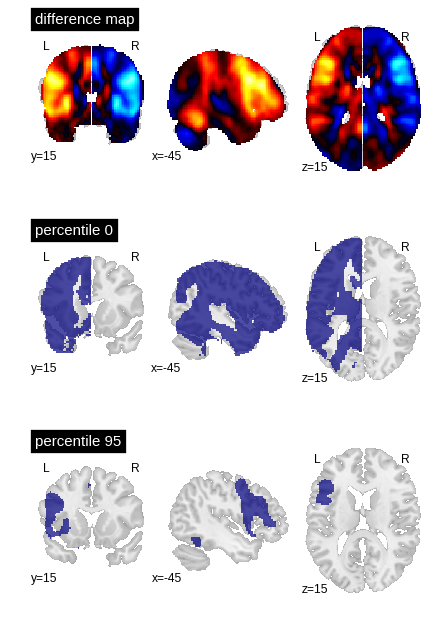

In [23]:
fig

In [24]:
fig.savefig('%s/reports/figures/04-roi-generation.png' % supDir,dpi=300,bbox_inches='tight')

### get ROI voxels into dataFrame

In [25]:
def makeRoiDf(tFile,roiFile):
    
    # get the range of valid voxel
    tBinIm = image.math_img('abs(img1)>0.001',img1=tFile)
    interimMasker = input_data.NiftiMasker(mask_img=tBinIm)
    interimMasker.fit()
    
    # get the overlap of valid voxel and the mask
    roiMask = interimMasker.inverse_transform(interimMasker.transform(roiFile))
    
    # initialize the final masker which is the overlap of tMap and roiFile
    masker = input_data.NiftiMasker(mask_img=roiMask).fit()
    
    # get data into array
    a = masker.transform( [tFile] )
    
    return a

In [26]:
makeRoiDf(tMap,threshRoi)

array([[ 3.11133027,  5.76102686,  6.31415319, ...,  2.53701282,
         2.10388064,  1.67110968]], dtype=float32)

### do everything for one ROI

In [27]:
def getRoiData(tMap,roi,thresh):

    # binarize the language ROI using the masker
    threshRoi = makeBinMask(roi,thresh)
    # use the binary language ROI as a masker for extracting the tMap data
    roiData = makeRoiDf(tMap,threshRoi)[-1]
    
    return roiData

In [28]:
roiData = getRoiData(tMap,languageLeft,1)

In [29]:
roiData

array([ 1.99167979,  1.95605922,  1.68535602, ..., -4.07275391,
       -4.89248657, -2.45053148], dtype=float32)

### count number of above-threshold voxel in ROI for a range of thresholds  

here, thresholding is done in 0.1 steps; output is the percentage of above-threshold voxel (relative to ROi size)

In [30]:
def getThresh(roiData,sideName):
    # empty dict to write to
    d = {}

    # number of voxel in ROI
    num_total = roiData.shape[-1]
    
    # fixed range of values (it does not make sense to go outside these boundaries)
    myMin = -10.0
    myMax = 20.0
    
    # loop through the whole range of t-Values in the ROI (from min to max)
    for threshold in np.arange(myMin,myMax,0.1):
        # find all above-threshold voxel and count them
        num_above = np.where(roiData>threshold)[-1].shape[-1]
        # get the percentage by dividing through total number of voxel in ROI
        percent_above = num_above/float(num_total)*100
        # in the dict, each key is a threshold and its value is the number of voxel above that threshold
        d[round(threshold,1)] = percent_above
    
    return pd.DataFrame(d,index=[sideName]).T

Example:

In [31]:
thisDf = getThresh(roiData,'left')

In [32]:
thisDf.T

,-10.0,-9.9,-9.8,-9.7,-9.6,-9.5,-9.4,-9.3,-9.2,-9.1,...,19.0,19.1,19.2,19.3,19.4,19.5,19.6,19.7,19.8,19.9
left,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


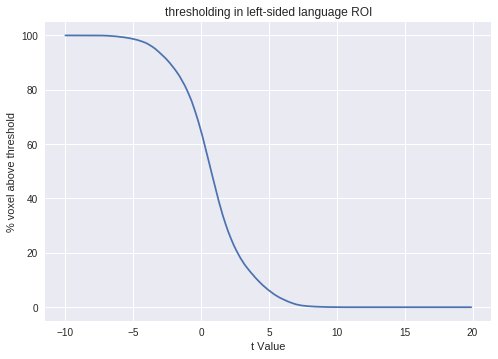

In [33]:
plt.plot( thisDf );
plt.xlabel('t Value')
plt.ylabel('% voxel above threshold')
plt.title('thresholding in left-sided language ROI')
plt.show()

### do this for both ROIs

Adjust ranges

In [34]:
def fillMissing(df):
    '''
    this makes sure that we do not have nans
    '''
    mergeDf = df.copy()
    
    # loop through all ROIs
    for roi in ['left','right']:
        
        # get the max and min value
        thisMax = mergeDf.idxmax()[roi]
        thisMin = mergeDf.idxmin()[roi]

        # fill everything above the max value with 100
        mergeDf[roi].loc[:thisMax].fillna(100.,inplace=True)
        # fill everything below the min value with 0
        mergeDf[roi].loc[thisMin:].fillna(0.,inplace=True)
    
    return mergeDf

Combine

In [35]:
def makeParticipant(tMap,pc):
    
    roiData = getRoiData(tMap,languageLeft,pc)
    threshDataLeft = getThresh(roiData,'left')
    
    roiData = getRoiData(tMap,languageRight,pc)
    threshDataRight = getThresh(roiData,'right')
    
    allRoiDf = pd.concat([threshDataLeft,threshDataRight],axis=1)
    fillDf = fillMissing(allRoiDf)

    return fillDf

Example:

In [36]:
pDf = makeParticipant(tMap,1)

In [37]:
pDf.T

,-10.0,-9.9,-9.8,-9.7,-9.6,-9.5,-9.4,-9.3,-9.2,-9.1,...,19.0,19.1,19.2,19.3,19.4,19.5,19.6,19.7,19.8,19.9
left,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
right,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


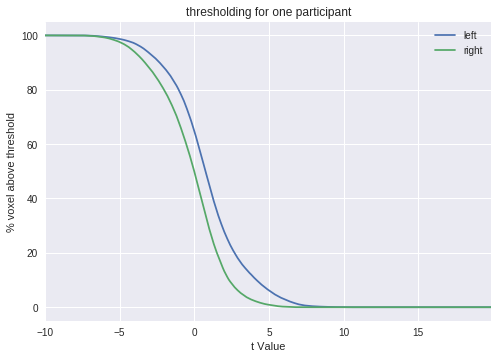

In [38]:
pDf.plot()
plt.xlabel('t Value')
plt.ylabel('% voxel above threshold')
plt.title('thresholding for one participant')
plt.show()

### do this for different ROI sizes  

In [39]:
def makeP(tMap):
    
    bigDf = pd.DataFrame()

    for i in range(0,96,5):

        pDf = makeParticipant(tMap,i).T
        pDf.index = [[i]*pDf.shape[0],pDf.index]
        bigDf = pd.concat([bigDf,pDf])
        
    return bigDf

In [40]:
pDf = makeP(tMap)

In [46]:
pDf.tail()

-10.0  -9.9   -9.8   -9.7   -9.6   -9.5   -9.4   -9.3   -9.2   \
85 right  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   
90 left   100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   
   right  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   
95 left   100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   
   right  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   

          -9.1   ...     19.0   19.1   19.2   19.3   19.4   19.5   19.6  \
85 right  100.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   
90 left   100.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   
   right  100.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   
95 left   100.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   
   right  100.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   

           19.7   19.8   19.9  
85 right    0.0    0.0    0.0  
90 left     0.0    0.0    0.0  
   right    0.0    0.0    0.0  
95 left     0.0    0.0    0.0  
   right    0.0    0.0    0.0  

[5 rows x 300 columns]

In [42]:
#def makeP(pFolder, pName):
#
#    tMap = '%s/tMap_%s.nii' % (pFolder, pName)
#
#    bigDf = pd.DataFrame()
#
#    for i in range(0, 96, 5):
#
#        pDf = makeParticipant(tMap, i).T
#        pDf.index = [[i] * pDf.shape[0], pDf.index]
#        bigDf = pd.concat([bigDf, pDf])
#
#    bigDf.to_csv('%s/roiPercentiles_%s.csv' % (pFolder, pName))
#
#    return bigDf

### do this for all

In [43]:
def makeBig(tDf, pName):

    tMap = tDf.loc[pName].tMaps
    bigDf = makeP(tMap)
    bigDf.to_csv('%s/data/interim/csv/roiPercentiles_%s.csv' % (supDir, pName))

    return bigDf

In [47]:
doneList = [
    x.split('tiles_')[-1].split('.')[0]
    for x in os.listdir('%s/data/interim/csv/' % supDir)
    if x.startswith('roiPercentiles')
]
len(doneList)

783

In [48]:
for pName in tDf.index:
    if pName not in doneList:
        try:
            thisDf = makeBig(tDf,pName)
            print pName
        except:
            print 'did not work for %s' % pName